## Continual learning on the MNIST permutation task


In [1]:
import torch
import torch.nn as nn
import os
import torchvision.transforms as transforms
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
import random
from torchvision import datasets
from torch.nn import functional as F
#from torch import nn
from torch import autograd

GPU = True
if GPU == True:
    torch.backends.cudnn.enabled = True
    torch.backends.cudnn.benchmark = True
    dtype = torch.cuda.FloatTensor
    os.environ['CUDA_VISIBLE_DEVICES'] = '0'
    print("num GPUs",torch.cuda.device_count())
else:
    dtype = torch.FloatTensor

from include import *

num GPUs 1


In [2]:
train_data = datasets.MNIST(root = './data', train = True,
                        transform = transforms.ToTensor(), download = True)

test_data = datasets.MNIST(root = './data', train = False,
                       transform = transforms.ToTensor())

### Get training and test data loader for permuated MNIST

In [9]:
class PermutedMNIST(datasets.MNIST):

    def __init__(self, root="~/.torch/data/mnist", train=True, permute_idx=None):
        super(PermutedMNIST, self).__init__(root, train, download=True)
        assert len(permute_idx) == 28 * 28
        self.data = torch.stack([img.float().view(-1)[permute_idx] / 255 for img in self.data])

    def __getitem__(self, index):
        img, target = self.data[index], self.targets[index]
        return img, target

    def get_sample(self, sample_size):
        sample_idx = random.sample(range(len(self)), sample_size)
        return [img for img in self.data[sample_idx]]
    
###
batch_size = 1 # the size of input data took for one iteration

def get_permute_mnist(num_tasks=5):
    train_loader = {}
    test_loader = {}
    idx = list(range(28 * 28))
    for i in range(num_tasks):
        print(i)
        #train_loader[i] = torch.utils.data.DataLoader(PermutedMNIST(train=True, permute_idx=idx),
        #                                              batch_size=batch_size,
        #                                              num_workers=4)
        train_loader[i] = torch.utils.data.DataLoader(PermutedMNIST(train=True, permute_idx=idx),
                                                      batch_size=batch_size)
        
        test_loader[i] = torch.utils.data.DataLoader(PermutedMNIST(train=False, permute_idx=idx),
                                                     batch_size=batch_size)
        random.shuffle(idx)
    return train_loader, test_loader

## Save a few example images

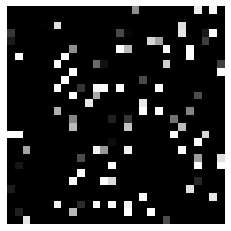

In [33]:
train_loader, test_loader = get_permute_mnist(3)

batch_size = 1 # the size of input data took for one iteration

def find_examples_imgs(train_gen,label=0,numex=8,prefix = ""):
    ex = []
    for i ,(images,labels) in enumerate(train_gen):
        if labels[0] == label:
            ex += [ images[0].reshape((28,28)) ]
            if len(ex) >= numex:
                break
    for i,img in enumerate(ex):
        plt.imshow(img,cmap='gray')
        plt.axis('off')
        plt.savefig( prefix + str(i) +".png" ,format='png',)
            
find_examples_imgs(train_loader[0], 0, prefix = "example_imgs/zeros_orig")
find_examples_imgs(train_loader[0], 1, prefix = "example_imgs/ones_orig")
find_examples_imgs(train_loader[1], 0, prefix = "example_imgs/ones_shuf")
find_examples_imgs(train_loader[1], 1, prefix = "example_imgs/ones_shuf")

## Code to evaluate the EWC variants, and training on all the data

In [5]:
def train_model(model,train_gen,ewc,num_epochs=20):
    optimizer = torch.optim.Adam( model.parameters(), lr=lr)
    #optimizer = torch.optim.SGD( model.parameters(), lr=lr)    
    for epoch in range(num_epochs):
        for i ,(images,labels) in enumerate(train_gen):
            images = Variable(images).cuda()
            labels = Variable(labels).cuda()
    
            optimizer.zero_grad()
            outputs = model(images)
            
            loss_function = nn.MSELoss()
            labels = torch.nn.functional.one_hot(labels).to(torch.float32)
            loss = loss_function(outputs, labels)
            #if i==0 and epoch==0:
            #    print("std:",loss.data)
            loss += ewc.loss(model)
            #if i==0 and epoch==0:
            #    print("ewc:",loss.data)
            loss.backward()
            optimizer.step()
    
            if i == 0: #and epoch == num_epochs - 1:
                print('Epoch [%d/%d], Loss: %.4f' %(epoch+1, num_epochs, loss.data.item()))

# train over multiple data loaders, used to evaluate performance for training on all sets
def train_model_over_sets(model,train_gens,num_epochs=20,shuffle=False):
    optimizer = torch.optim.Adam( model.parameters(), lr=lr)
    #optimizer = torch.optim.SGD( model.parameters(), lr=lr)

    for epoch in range(num_epochs):
        
        if shuffle:
            perm = np.random.permutation(len(train_gens))
        else:
            perm = [i for i in range( len(train_gens) )]
    
        for j in perm:
            train_gen = train_gens[j]
            for i ,(images,labels) in enumerate(train_gen):
                images = Variable(images).cuda()
                labels = Variable(labels).cuda()
    
                optimizer.zero_grad()
                outputs = model(images)
                
                loss_function = nn.MSELoss()
                labels = torch.nn.functional.one_hot(labels).to(torch.float32)
                loss = loss_function(outputs, labels)
                
                loss.backward()
                optimizer.step()
    
                if i == 0:
                    print('Epoch [%d/%d], Loss: %.4f' %(epoch+1, num_epochs, loss.data.item()))
                 
def test_model(model,test_gen):
    correct = 0
    total = 0
    for images,labels in test_gen:
        images = Variable(images).cuda()
        labels = labels.cuda()
  
        output = model(images)
        _, predicted = torch.max(output,1)
        correct += (predicted == labels).sum()
        total += labels.size(0)
    #return ((100.0*correct)/(total+1))
    return ((100.0*correct)/(total))

In [6]:
def run_simulation(net,train_loader,test_loader,ewc,num_epochs=20):
    #net = Net(input_size, hidden_size, num_classes).cuda()
    num_tasks = len(train_loader)
    res = np.zeros(num_tasks)
    for k in range(num_tasks): 
        
        # train model
        train_model(net,train_loader[k],ewc,num_epochs=num_epochs)
        # compute Hessian before updating
        if ewc.lam>0 and k < num_tasks-1:
            #ewc.compute_data( net,train_loader[k] )
            ewc.update( net,train_loader[k] )

        inderrors = []
        for i in range(k+1):
            erri = test_model(net,test_loader[i])
            inderrors += [erri]
            res[k] += erri / (k+1)
        print("test performance : ", res)
        print("individual errors: ", inderrors)
    return res

def train_on_all(net,train_loader,test_loader,num_epochs=20,shuffle=False):
    #net = Net(input_size, hidden_size, num_classes).cuda()
    num_tasks = len(train_loader)
    res = np.zeros(num_tasks)
    for k in range(num_tasks): 
        train_model_over_sets(net,[train_loader[j] for j in range(k+1)],num_epochs=20,shuffle=shuffle)
        for i in range(k+1):
            res[k] += test_model(net,test_loader[i]) / (k+1)
    return res

# Two layer neural network

In [9]:
class Net(nn.Module):
    def __init__(self, input_size=784, hidden_size=500, num_classes=10):
        super(Net,self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)
  
    def forward(self,x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

def get_random_feature_model(input_size = 784,hidden_size = 6*784,num_classes = 10):
    net = Net(input_size, hidden_size, num_classes).cuda()
    for param in net.fc1.parameters():
        param.requires_grad = False
    return net

In [10]:
num_tasks = 10
#num_classes = 10 # number of output classes discrete range [0,9]
num_epochs = 20 # number of times which the entire dataset is passed throughout the model
batch_size = 100 # the size of input data took for one iteration
lr = 2e-4 # size of step

In [11]:
train_loader, test_loader = get_permute_mnist(num_tasks)

0
1
2
3
4
5
6
7
8
9


In [ ]:
respp = run_simulation( Net().cuda(),train_loader,test_loader,EWCplusplus(lam=2e-4,s=100),num_epochs=num_epochs )

In [18]:
resppbig = run_simulation( Net().cuda(),train_loader,test_loader,EWCplusplus(lam=2e-4,s=400),num_epochs=num_epochs )

EWC++  400 0.0002
Epoch [1/20], Loss: 0.1097
Epoch [2/20], Loss: 0.0142
Epoch [3/20], Loss: 0.0105
Epoch [4/20], Loss: 0.0087
Epoch [5/20], Loss: 0.0077
Epoch [6/20], Loss: 0.0070
Epoch [7/20], Loss: 0.0065
Epoch [8/20], Loss: 0.0061
Epoch [9/20], Loss: 0.0058
Epoch [10/20], Loss: 0.0056
Epoch [11/20], Loss: 0.0054
Epoch [12/20], Loss: 0.0052
Epoch [13/20], Loss: 0.0051
Epoch [14/20], Loss: 0.0050
Epoch [15/20], Loss: 0.0048
Epoch [16/20], Loss: 0.0047
Epoch [17/20], Loss: 0.0046
Epoch [18/20], Loss: 0.0045
Epoch [19/20], Loss: 0.0044
Epoch [20/20], Loss: 0.0043
generate task data..
task data norm and number entries: tensor(4675.7065, device='cuda:0') torch.Size([400, 397510])
..done
test performance :  [98.20999908  0.          0.          0.          0.          0.
  0.          0.          0.          0.        ]
individual errors:  [tensor(98.2100, device='cuda:0')]
Epoch [1/20], Loss: 0.1001
Epoch [2/20], Loss: 0.0173
Epoch [3/20], Loss: 0.0134
Epoch [4/20], Loss: 0.0114
Epoch [5/

Epoch [14/20], Loss: 0.0088
Epoch [15/20], Loss: 0.0087
Epoch [16/20], Loss: 0.0084
Epoch [17/20], Loss: 0.0083
Epoch [18/20], Loss: 0.0085
Epoch [19/20], Loss: 0.0087
Epoch [20/20], Loss: 0.0076
update data..
task data norm and number entries: tensor(3908.0073, device='cuda:0') torch.Size([400, 397510])
..done
test performance :  [98.20999908 97.93499756 97.70999908 97.46749878 97.12599182 96.87667084
 96.60285187 96.37000275 96.21777344  0.        ]
individual errors:  [tensor(94.8300, device='cuda:0'), tensor(95.5300, device='cuda:0'), tensor(95.7200, device='cuda:0'), tensor(96.2100, device='cuda:0'), tensor(96.6800, device='cuda:0'), tensor(96.5900, device='cuda:0'), tensor(96.8500, device='cuda:0'), tensor(96.7000, device='cuda:0'), tensor(96.8500, device='cuda:0')]
Epoch [1/20], Loss: 0.0971
Epoch [2/20], Loss: 0.0234
Epoch [3/20], Loss: 0.0164
Epoch [4/20], Loss: 0.0155
Epoch [5/20], Loss: 0.0138
Epoch [6/20], Loss: 0.0129
Epoch [7/20], Loss: 0.0115
Epoch [8/20], Loss: 0.0109
E

In [13]:
# train on all data as baseline
resall = train_on_all( Net().cuda(),train_loader,test_loader,num_epochs=num_epochs)

Epoch [1/20], Loss: 0.1018
Epoch [2/20], Loss: 0.0139
Epoch [3/20], Loss: 0.0107
Epoch [4/20], Loss: 0.0092
Epoch [5/20], Loss: 0.0082
Epoch [6/20], Loss: 0.0075
Epoch [7/20], Loss: 0.0069
Epoch [8/20], Loss: 0.0065
Epoch [9/20], Loss: 0.0062
Epoch [10/20], Loss: 0.0059
Epoch [11/20], Loss: 0.0057
Epoch [12/20], Loss: 0.0055
Epoch [13/20], Loss: 0.0053
Epoch [14/20], Loss: 0.0052
Epoch [15/20], Loss: 0.0050
Epoch [16/20], Loss: 0.0049
Epoch [17/20], Loss: 0.0047
Epoch [18/20], Loss: 0.0046
Epoch [19/20], Loss: 0.0045
Epoch [20/20], Loss: 0.0043
Epoch [1/20], Loss: 0.0042
Epoch [1/20], Loss: 0.1093
Epoch [2/20], Loss: 0.0130
Epoch [2/20], Loss: 0.0131
Epoch [3/20], Loss: 0.0068
Epoch [3/20], Loss: 0.0106
Epoch [4/20], Loss: 0.0069
Epoch [4/20], Loss: 0.0094
Epoch [5/20], Loss: 0.0069
Epoch [5/20], Loss: 0.0088
Epoch [6/20], Loss: 0.0072
Epoch [6/20], Loss: 0.0082
Epoch [7/20], Loss: 0.0072
Epoch [7/20], Loss: 0.0078
Epoch [8/20], Loss: 0.0069
Epoch [8/20], Loss: 0.0073
Epoch [9/20], Los

Epoch [20/20], Loss: 0.0049
Epoch [20/20], Loss: 0.0062
Epoch [1/20], Loss: 0.0025
Epoch [1/20], Loss: 0.0034
Epoch [1/20], Loss: 0.0043
Epoch [1/20], Loss: 0.0055
Epoch [1/20], Loss: 0.0070
Epoch [1/20], Loss: 0.1001
Epoch [2/20], Loss: 0.0103
Epoch [2/20], Loss: 0.0053
Epoch [2/20], Loss: 0.0051
Epoch [2/20], Loss: 0.0054
Epoch [2/20], Loss: 0.0063
Epoch [2/20], Loss: 0.0262
Epoch [3/20], Loss: 0.0040
Epoch [3/20], Loss: 0.0038
Epoch [3/20], Loss: 0.0046
Epoch [3/20], Loss: 0.0049
Epoch [3/20], Loss: 0.0059
Epoch [3/20], Loss: 0.0164
Epoch [4/20], Loss: 0.0035
Epoch [4/20], Loss: 0.0034
Epoch [4/20], Loss: 0.0045
Epoch [4/20], Loss: 0.0050
Epoch [4/20], Loss: 0.0058
Epoch [4/20], Loss: 0.0140
Epoch [5/20], Loss: 0.0034
Epoch [5/20], Loss: 0.0033
Epoch [5/20], Loss: 0.0043
Epoch [5/20], Loss: 0.0049
Epoch [5/20], Loss: 0.0057
Epoch [5/20], Loss: 0.0125
Epoch [6/20], Loss: 0.0032
Epoch [6/20], Loss: 0.0032
Epoch [6/20], Loss: 0.0042
Epoch [6/20], Loss: 0.0048
Epoch [6/20], Loss: 0.0056

Epoch [5/20], Loss: 0.0053
Epoch [5/20], Loss: 0.0070
Epoch [5/20], Loss: 0.0138
Epoch [6/20], Loss: 0.0018
Epoch [6/20], Loss: 0.0031
Epoch [6/20], Loss: 0.0036
Epoch [6/20], Loss: 0.0040
Epoch [6/20], Loss: 0.0039
Epoch [6/20], Loss: 0.0052
Epoch [6/20], Loss: 0.0069
Epoch [6/20], Loss: 0.0128
Epoch [7/20], Loss: 0.0019
Epoch [7/20], Loss: 0.0031
Epoch [7/20], Loss: 0.0035
Epoch [7/20], Loss: 0.0040
Epoch [7/20], Loss: 0.0039
Epoch [7/20], Loss: 0.0052
Epoch [7/20], Loss: 0.0069
Epoch [7/20], Loss: 0.0121
Epoch [8/20], Loss: 0.0019
Epoch [8/20], Loss: 0.0030
Epoch [8/20], Loss: 0.0035
Epoch [8/20], Loss: 0.0039
Epoch [8/20], Loss: 0.0039
Epoch [8/20], Loss: 0.0051
Epoch [8/20], Loss: 0.0069
Epoch [8/20], Loss: 0.0116
Epoch [9/20], Loss: 0.0019
Epoch [9/20], Loss: 0.0031
Epoch [9/20], Loss: 0.0034
Epoch [9/20], Loss: 0.0039
Epoch [9/20], Loss: 0.0038
Epoch [9/20], Loss: 0.0051
Epoch [9/20], Loss: 0.0068
Epoch [9/20], Loss: 0.0111
Epoch [10/20], Loss: 0.0017
Epoch [10/20], Loss: 0.0031

Epoch [20/20], Loss: 0.0034
Epoch [20/20], Loss: 0.0035
Epoch [20/20], Loss: 0.0046
Epoch [20/20], Loss: 0.0054
Epoch [20/20], Loss: 0.0055
Epoch [20/20], Loss: 0.0082
Epoch [1/20], Loss: 0.0014
Epoch [1/20], Loss: 0.0019
Epoch [1/20], Loss: 0.0035
Epoch [1/20], Loss: 0.0035
Epoch [1/20], Loss: 0.0037
Epoch [1/20], Loss: 0.0065
Epoch [1/20], Loss: 0.0063
Epoch [1/20], Loss: 0.0068
Epoch [1/20], Loss: 0.0091
Epoch [1/20], Loss: 0.0968
Epoch [2/20], Loss: 0.0076
Epoch [2/20], Loss: 0.0062
Epoch [2/20], Loss: 0.0054
Epoch [2/20], Loss: 0.0051
Epoch [2/20], Loss: 0.0042
Epoch [2/20], Loss: 0.0051
Epoch [2/20], Loss: 0.0068
Epoch [2/20], Loss: 0.0058
Epoch [2/20], Loss: 0.0079
Epoch [2/20], Loss: 0.0406
Epoch [3/20], Loss: 0.0024
Epoch [3/20], Loss: 0.0029
Epoch [3/20], Loss: 0.0037
Epoch [3/20], Loss: 0.0044
Epoch [3/20], Loss: 0.0038
Epoch [3/20], Loss: 0.0050
Epoch [3/20], Loss: 0.0059
Epoch [3/20], Loss: 0.0059
Epoch [3/20], Loss: 0.0079
Epoch [3/20], Loss: 0.0213
Epoch [4/20], Loss: 0.

In [15]:
# train on all but shuffle
resall_shuffle = train_on_all( Net().cuda(),train_loader,test_loader,num_epochs=num_epochs,shuffle=True)

Epoch [1/20], Loss: 0.1097
Epoch [2/20], Loss: 0.0143
Epoch [3/20], Loss: 0.0109
Epoch [4/20], Loss: 0.0092
Epoch [5/20], Loss: 0.0083
Epoch [6/20], Loss: 0.0076
Epoch [7/20], Loss: 0.0070
Epoch [8/20], Loss: 0.0065
Epoch [9/20], Loss: 0.0061
Epoch [10/20], Loss: 0.0058
Epoch [11/20], Loss: 0.0055
Epoch [12/20], Loss: 0.0052
Epoch [13/20], Loss: 0.0050
Epoch [14/20], Loss: 0.0048
Epoch [15/20], Loss: 0.0046
Epoch [16/20], Loss: 0.0045
Epoch [17/20], Loss: 0.0043
Epoch [18/20], Loss: 0.0042
Epoch [19/20], Loss: 0.0041
Epoch [20/20], Loss: 0.0040
Epoch [1/20], Loss: 0.1081
Epoch [1/20], Loss: 0.0202
Epoch [2/20], Loss: 0.0162
Epoch [2/20], Loss: 0.0072
Epoch [3/20], Loss: 0.0119
Epoch [3/20], Loss: 0.0071
Epoch [4/20], Loss: 0.0101
Epoch [4/20], Loss: 0.0066
Epoch [5/20], Loss: 0.0089
Epoch [5/20], Loss: 0.0063
Epoch [6/20], Loss: 0.0039
Epoch [6/20], Loss: 0.0085
Epoch [7/20], Loss: 0.0057
Epoch [7/20], Loss: 0.0076
Epoch [8/20], Loss: 0.0060
Epoch [8/20], Loss: 0.0071
Epoch [9/20], Los

Epoch [20/20], Loss: 0.0069
Epoch [20/20], Loss: 0.0050
Epoch [1/20], Loss: 0.0025
Epoch [1/20], Loss: 0.0022
Epoch [1/20], Loss: 0.0039
Epoch [1/20], Loss: 0.0053
Epoch [1/20], Loss: 0.0080
Epoch [1/20], Loss: 0.0976
Epoch [2/20], Loss: 0.0106
Epoch [2/20], Loss: 0.0045
Epoch [2/20], Loss: 0.0073
Epoch [2/20], Loss: 0.0045
Epoch [2/20], Loss: 0.0034
Epoch [2/20], Loss: 0.0287
Epoch [3/20], Loss: 0.0076
Epoch [3/20], Loss: 0.0030
Epoch [3/20], Loss: 0.0044
Epoch [3/20], Loss: 0.0034
Epoch [3/20], Loss: 0.0178
Epoch [3/20], Loss: 0.0080
Epoch [4/20], Loss: 0.0139
Epoch [4/20], Loss: 0.0052
Epoch [4/20], Loss: 0.0031
Epoch [4/20], Loss: 0.0048
Epoch [4/20], Loss: 0.0072
Epoch [4/20], Loss: 0.0028
Epoch [5/20], Loss: 0.0059
Epoch [5/20], Loss: 0.0049
Epoch [5/20], Loss: 0.0022
Epoch [5/20], Loss: 0.0046
Epoch [5/20], Loss: 0.0026
Epoch [5/20], Loss: 0.0189
Epoch [6/20], Loss: 0.0054
Epoch [6/20], Loss: 0.0029
Epoch [6/20], Loss: 0.0022
Epoch [6/20], Loss: 0.0133
Epoch [6/20], Loss: 0.0052

Epoch [5/20], Loss: 0.0224
Epoch [5/20], Loss: 0.0065
Epoch [5/20], Loss: 0.0025
Epoch [6/20], Loss: 0.0013
Epoch [6/20], Loss: 0.0021
Epoch [6/20], Loss: 0.0032
Epoch [6/20], Loss: 0.0034
Epoch [6/20], Loss: 0.0099
Epoch [6/20], Loss: 0.0165
Epoch [6/20], Loss: 0.0063
Epoch [6/20], Loss: 0.0055
Epoch [7/20], Loss: 0.0037
Epoch [7/20], Loss: 0.0087
Epoch [7/20], Loss: 0.0125
Epoch [7/20], Loss: 0.0041
Epoch [7/20], Loss: 0.0029
Epoch [7/20], Loss: 0.0036
Epoch [7/20], Loss: 0.0025
Epoch [7/20], Loss: 0.0057
Epoch [8/20], Loss: 0.0047
Epoch [8/20], Loss: 0.0123
Epoch [8/20], Loss: 0.0022
Epoch [8/20], Loss: 0.0055
Epoch [8/20], Loss: 0.0034
Epoch [8/20], Loss: 0.0099
Epoch [8/20], Loss: 0.0016
Epoch [8/20], Loss: 0.0035
Epoch [9/20], Loss: 0.0125
Epoch [9/20], Loss: 0.0031
Epoch [9/20], Loss: 0.0048
Epoch [9/20], Loss: 0.0018
Epoch [9/20], Loss: 0.0032
Epoch [9/20], Loss: 0.0057
Epoch [9/20], Loss: 0.0090
Epoch [9/20], Loss: 0.0023
Epoch [10/20], Loss: 0.0030
Epoch [10/20], Loss: 0.0016

Epoch [20/20], Loss: 0.0031
Epoch [20/20], Loss: 0.0059
Epoch [20/20], Loss: 0.0055
Epoch [20/20], Loss: 0.0024
Epoch [20/20], Loss: 0.0047
Epoch [20/20], Loss: 0.0032
Epoch [1/20], Loss: 0.0056
Epoch [1/20], Loss: 0.0055
Epoch [1/20], Loss: 0.0031
Epoch [1/20], Loss: 0.0023
Epoch [1/20], Loss: 0.0986
Epoch [1/20], Loss: 0.0274
Epoch [1/20], Loss: 0.0135
Epoch [1/20], Loss: 0.0085
Epoch [1/20], Loss: 0.0061
Epoch [1/20], Loss: 0.0069
Epoch [2/20], Loss: 0.0032
Epoch [2/20], Loss: 0.0039
Epoch [2/20], Loss: 0.0357
Epoch [2/20], Loss: 0.0074
Epoch [2/20], Loss: 0.0048
Epoch [2/20], Loss: 0.0078
Epoch [2/20], Loss: 0.0090
Epoch [2/20], Loss: 0.0080
Epoch [2/20], Loss: 0.0029
Epoch [2/20], Loss: 0.0049
Epoch [3/20], Loss: 0.0021
Epoch [3/20], Loss: 0.0077
Epoch [3/20], Loss: 0.0051
Epoch [3/20], Loss: 0.0239
Epoch [3/20], Loss: 0.0053
Epoch [3/20], Loss: 0.0026
Epoch [3/20], Loss: 0.0068
Epoch [3/20], Loss: 0.0056
Epoch [3/20], Loss: 0.0070
Epoch [3/20], Loss: 0.0044
Epoch [4/20], Loss: 0.

In [20]:
lam = 1e-6
resewc = run_simulation( Net().cuda(),train_loader,test_loader,EWC(lam=lam),num_epochs=num_epochs )

EWC 1e-06
Epoch [1/20], Loss: 0.1047
Epoch [2/20], Loss: 0.0142
Epoch [3/20], Loss: 0.0110
Epoch [4/20], Loss: 0.0094
Epoch [5/20], Loss: 0.0084
Epoch [6/20], Loss: 0.0076
Epoch [7/20], Loss: 0.0070
Epoch [8/20], Loss: 0.0066
Epoch [9/20], Loss: 0.0062
Epoch [10/20], Loss: 0.0059
Epoch [11/20], Loss: 0.0056
Epoch [12/20], Loss: 0.0053
Epoch [13/20], Loss: 0.0051
Epoch [14/20], Loss: 0.0049
Epoch [15/20], Loss: 0.0048
Epoch [16/20], Loss: 0.0046
Epoch [17/20], Loss: 0.0045
Epoch [18/20], Loss: 0.0043
Epoch [19/20], Loss: 0.0042
Epoch [20/20], Loss: 0.0041
generate task data..
task data norm and number entries: tensor(297162., device='cuda:0') torch.Size([397510])
..done
test performance :  [98.26999664  0.          0.          0.          0.          0.
  0.          0.          0.          0.        ]
individual errors:  [tensor(98.2700, device='cuda:0')]
Epoch [1/20], Loss: 0.1014
Epoch [2/20], Loss: 0.0151
Epoch [3/20], Loss: 0.0115
Epoch [4/20], Loss: 0.0100
Epoch [5/20], Loss: 0.00

Epoch [15/20], Loss: 0.0136
Epoch [16/20], Loss: 0.0135
Epoch [17/20], Loss: 0.0135
Epoch [18/20], Loss: 0.0134
Epoch [19/20], Loss: 0.0133
Epoch [20/20], Loss: 0.0133
update data..
task data norm and number entries: tensor(347286.4062, device='cuda:0') torch.Size([397510])
..done
test performance :  [98.26999664 97.98500061 97.70666504 97.38999939 97.22000122 96.92333984
 96.74000549 96.60500336 96.3188858   0.        ]
individual errors:  [tensor(95.0200, device='cuda:0'), tensor(96.0200, device='cuda:0'), tensor(96.0700, device='cuda:0'), tensor(96.4700, device='cuda:0'), tensor(96.6000, device='cuda:0'), tensor(96.5200, device='cuda:0'), tensor(96.6500, device='cuda:0'), tensor(96.7500, device='cuda:0'), tensor(96.7700, device='cuda:0')]
Epoch [1/20], Loss: 0.0965
Epoch [2/20], Loss: 0.0204
Epoch [3/20], Loss: 0.0176
Epoch [4/20], Loss: 0.0164
Epoch [5/20], Loss: 0.0157
Epoch [6/20], Loss: 0.0152
Epoch [7/20], Loss: 0.0149
Epoch [8/20], Loss: 0.0146
Epoch [9/20], Loss: 0.0145
Epoch

L2 1e-06
Epoch [1/20], Loss: 0.1016
Epoch [2/20], Loss: 0.0144
Epoch [3/20], Loss: 0.0107
Epoch [4/20], Loss: 0.0090
Epoch [5/20], Loss: 0.0080
Epoch [6/20], Loss: 0.0073
Epoch [7/20], Loss: 0.0067
Epoch [8/20], Loss: 0.0064
Epoch [9/20], Loss: 0.0060
Epoch [10/20], Loss: 0.0058
Epoch [11/20], Loss: 0.0055
Epoch [12/20], Loss: 0.0053
Epoch [13/20], Loss: 0.0051
Epoch [14/20], Loss: 0.0049
Epoch [15/20], Loss: 0.0048
Epoch [16/20], Loss: 0.0046
Epoch [17/20], Loss: 0.0045
Epoch [18/20], Loss: 0.0044
Epoch [19/20], Loss: 0.0042
Epoch [20/20], Loss: 0.0041


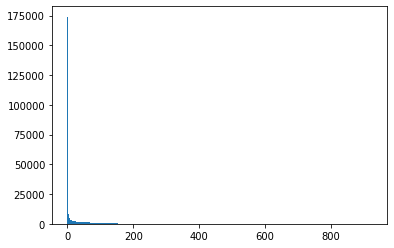

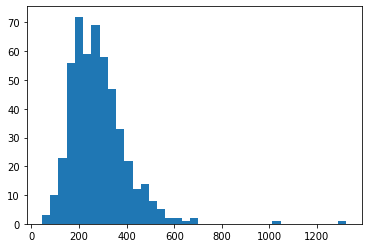

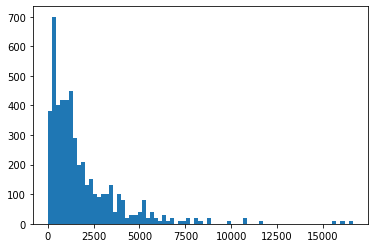

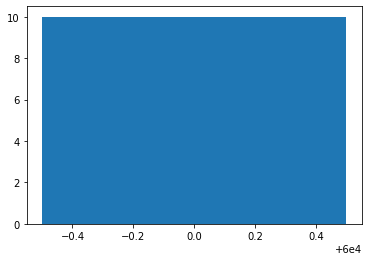

task data norm and number entries: tensor(234290.7969, device='cuda:0') torch.Size([397510])
test performance :  [98.26999664  0.          0.          0.          0.          0.
  0.          0.          0.          0.        ]
individual errors:  [tensor(98.2700, device='cuda:0')]
Epoch [1/20], Loss: 0.0996
Epoch [2/20], Loss: 0.0154
Epoch [3/20], Loss: 0.0131
Epoch [4/20], Loss: 0.0122
Epoch [5/20], Loss: 0.0117
Epoch [6/20], Loss: 0.0113
Epoch [7/20], Loss: 0.0110
Epoch [8/20], Loss: 0.0107
Epoch [9/20], Loss: 0.0105
Epoch [10/20], Loss: 0.0104
Epoch [11/20], Loss: 0.0102
Epoch [12/20], Loss: 0.0101
Epoch [13/20], Loss: 0.0100
Epoch [14/20], Loss: 0.0099
Epoch [15/20], Loss: 0.0099
Epoch [16/20], Loss: 0.0098
Epoch [17/20], Loss: 0.0098
Epoch [18/20], Loss: 0.0097
Epoch [19/20], Loss: 0.0097
Epoch [20/20], Loss: 0.0096
test performance :  [98.26999664 97.68499756  0.          0.          0.          0.
  0.          0.          0.          0.        ]
individual errors:  [tensor(97.

In [23]:
# with the best lambda = 1e-6
l2new = run_simulation( Net().cuda(),train_loader,test_loader,L2(lam=1e-6),num_epochs=num_epochs )

In [25]:
noreg = run_simulation( Net().cuda(),train_loader,test_loader,L2(lam=0),num_epochs=num_epochs )

L2 0
Epoch [1/20], Loss: 0.1094
Epoch [2/20], Loss: 0.0141
Epoch [3/20], Loss: 0.0106
Epoch [4/20], Loss: 0.0090
Epoch [5/20], Loss: 0.0080
Epoch [6/20], Loss: 0.0073
Epoch [7/20], Loss: 0.0069
Epoch [8/20], Loss: 0.0065
Epoch [9/20], Loss: 0.0062
Epoch [10/20], Loss: 0.0059
Epoch [11/20], Loss: 0.0057
Epoch [12/20], Loss: 0.0054
Epoch [13/20], Loss: 0.0053
Epoch [14/20], Loss: 0.0051
Epoch [15/20], Loss: 0.0048
Epoch [16/20], Loss: 0.0047
Epoch [17/20], Loss: 0.0045
Epoch [18/20], Loss: 0.0044
Epoch [19/20], Loss: 0.0043
Epoch [20/20], Loss: 0.0042
test performance :  [98.1499939  0.         0.         0.         0.         0.
  0.         0.         0.         0.       ]
individual errors:  [tensor(98.1500, device='cuda:0')]
Epoch [1/20], Loss: 0.1015
Epoch [2/20], Loss: 0.0137
Epoch [3/20], Loss: 0.0105
Epoch [4/20], Loss: 0.0089
Epoch [5/20], Loss: 0.0078
Epoch [6/20], Loss: 0.0070
Epoch [7/20], Loss: 0.0065
Epoch [8/20], Loss: 0.0060
Epoch [9/20], Loss: 0.0057
Epoch [10/20], Loss:

Epoch [12/20], Loss: 0.0072
Epoch [13/20], Loss: 0.0069
Epoch [14/20], Loss: 0.0067
Epoch [15/20], Loss: 0.0065
Epoch [16/20], Loss: 0.0063
Epoch [17/20], Loss: 0.0061
Epoch [18/20], Loss: 0.0059
Epoch [19/20], Loss: 0.0058
Epoch [20/20], Loss: 0.0057
test performance :  [98.1499939  83.08999634 77.29666901 68.36000061 64.93999481 55.65999985
 52.50428391 50.11000061 50.23666382 47.58599854]
individual errors:  [tensor(16.1900, device='cuda:0'), tensor(13.5100, device='cuda:0'), tensor(26.5600, device='cuda:0'), tensor(25.2500, device='cuda:0'), tensor(37.5300, device='cuda:0'), tensor(51.8500, device='cuda:0'), tensor(57.4500, device='cuda:0'), tensor(65.8500, device='cuda:0'), tensor(84.5900, device='cuda:0'), tensor(97.0800, device='cuda:0')]


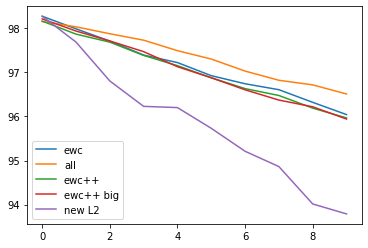

In [27]:
plt.plot(resewc,label='ewc')
plt.plot(resall,label='all')
#plt.plot(resall_shuffle,label='all shuffle')
plt.plot(respp,label='ewc++')
plt.plot(resppbig,label='ewc++ big')
plt.plot(l2new,label='new L2')
#plt.plot(l2newrecomp,label='L2 - recomp')
#plt.plot(noreg,label='noreg')


plt.legend()
plt.show()

In [28]:
results = [resewc,resall,respp,resppbig,l2new]

def res_to_mtx(losses,filename):
    ks = [i for i in range(len(losses[0]))]
    A = [np.array(ks)]
    A += losses
    A = np.vstack( A ).T
    print(A.shape)
    np.savetxt(filename, A, delimiter=' ')

res_to_mtx(results,"MNIST_permutation_2layernn.dat")

(10, 6)
